In [5]:
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/laptopPrice.csv')
# Создание подключения к базе данных SQLite
conn = sqlite3.connect('/content/laptopPrice.db')

# Загрузка датафрейма в новую таблицу базы данных SQLite
df.to_sql('laptop_price', conn, if_exists='replace', index=False)

# Проверка, что таблица была успешно создана
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [6]:
query = "SELECT * FROM laptop_price"
df = pd.read_sql_query(query, conn)
df.head()

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
3,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
4,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


In [7]:
for col in df.select_dtypes(include=[np.number]).columns:
    fig = px.histogram(df, x=col, marginal="box", nbins=50, title=f'Распределение {col}')
    fig.show()

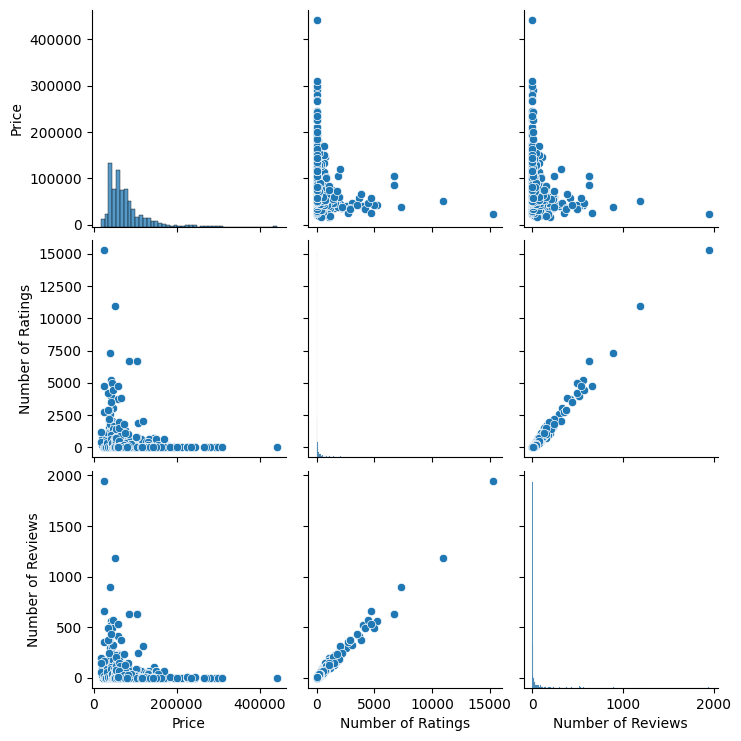

In [8]:
sns.pairplot(df.select_dtypes(include=[np.number]))
plt.show()

In [9]:
for col1 in df.select_dtypes(include=[np.number]).columns:
    for col2 in df.select_dtypes(include=[np.number]).columns:
        fig = px.scatter(df, x=col1, y=col2, title=f'Диаграмма рассеяния: {col1} vs {col2}')
        fig.show()

In [10]:
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()
fig = px.imshow(corr, x=corr.columns, y=corr.columns, title='Карта корреляции', labels=dict(color="Корреляция"))
fig.show()

In [11]:
labelencoder = LabelEncoder()
df_categorical = df.select_dtypes(include=[object])
df_categorical = df_categorical.apply(labelencoder.fit_transform)
df_numerical = df.select_dtypes(include=[np.number])
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_numerical)
df_numerical_scaled = pd.DataFrame(df_numerical_scaled, columns=df_numerical.columns)
df_preprocessed = pd.concat([df_numerical_scaled, df_categorical], axis=1)
print(df_preprocessed.head())

      Price  Number of Ratings  Number of Reviews  brand  processor_brand  \
0 -0.933927          -0.298354          -0.309155      1                1   
1 -0.837420          -0.239123          -0.268055      5                1   
2 -0.815234          -0.293578          -0.300935      5                1   
3 -0.149867          -0.301220          -0.309155      1                1   
4 -1.103846          -0.301220          -0.309155      1                1   

   processor_name  processor_gnrtn  ram_gb  ram_type  ssd  hdd  os  os_bit  \
0               1                0       2         1    0    1   2       1   
1               1                0       2         1    0    1   2       1   
2               1                0       2         1    0    1   2       1   
3               2                0       3         1    6    0   2       0   
4               0                7       2         1    0    3   2       1   

   graphic_card_gb  weight  warranty  Touchscreen  msoffice  rating 

In [12]:
pca = PCA()
pca.fit(df_preprocessed)
fig = px.line(x=range(1, len(pca.explained_variance_ratio_) + 1), y=pca.explained_variance_ratio_,
              labels={'x': 'Главная компонента', 'y': 'Доля объясненной дисперсии'},
              title='Доля объясненной дисперсии PCA')
fig.show()

In [14]:
df = pd.get_dummies(df, drop_first=True)
y = df['Price']
X = df.drop('Price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, predictions_lr))
r2_lr = r2_score(y_test, predictions_lr)

model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))
r2_rf = r2_score(y_test, predictions_rf)

In [15]:
model_metrics = {'Линейная регрессия': [rmse_lr, r2_lr], 'Случайный лес': [rmse_rf, r2_rf]}

for model, metrics in model_metrics.items():
    print(f'Метрики для {model}:')
    print('Среднеквадратическое отклонение: ', metrics[0])
    print('R2-оценка: ', metrics[1])

Метрики для Линейная регрессия:
Среднеквадратическое отклонение:  24008.542545320597
R2-оценка:  0.7042241051300424
Метрики для Случайный лес:
Среднеквадратическое отклонение:  22218.94616697833
R2-оценка:  0.7466749733460987
